In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:20<00:00, 42.6MB/s]
100% 812M/812M [00:20<00:00, 41.7MB/s]


In [3]:
!unzip dogs-vs-cats.zip
!unzip test1.zip
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [4]:
!pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.1 MB/s eta 0:00:00


In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import captum
from captum.attr import IntegratedGradients, LayerGradCam
from captum.attr import visualization as viz

Importing the required libraries including captum and torch. I have done the classification using pytorch and captum to visualise the black boxing of the backpropogation. Also used opencv library for some tasks as I have used this library for similar tasks.

In [6]:
torch.manual_seed(69)
np.random.seed(69)
random.seed(69)

Setting random seed of numpy and torch for reproducibility of data and model.

In [7]:
class imgdataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.img_list = os.listdir(root_dir)

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    img_name=self.img_list[idx]
    img_path=os.path.join(self.root_dir, img_name)
    image=Image.open(img_path).convert('RGB')
    label=1 if 'dog' in img_name else 0
    if self.transform:
      image=self.transform(image)
    return image, label

Initializing the root directory for storage of images, transforming of images such as resizing.
Getting the length of the image.
Getting the images and using transformation on the images.

In [8]:
data_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using data augmentation for training dataset.

In [9]:
dataset_train=imgdataset('train', transform=data_transform)
train_loader=DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)
dataset_test=imgdataset('test1', transform=data_transform)
test_loader=DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=2)

Splitting the dataset into train and test set using train loader and test loader for not going out of memory while loading the data. No of workers are 2 for parallelization ie splitting work load.

In [184]:
model=models.resnet18(pretrained=True)
model.fc=nn.Linear(model.fc.in_features, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using a pretrained binary classification resnet18 model for model creation. I have used it as it is trained on large image dataset which generalises features of the image.

In [11]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

Using binary cross entropy as loss function from torch.nn module and using Adam optimizer which is a special type of stochastic gradient descent algorithm.

In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using GPU architechture and using cuda acceleration libraries.

In [13]:
# epochs=10
# for epoch in range(epochs):
#   model.train()
#   runningloss=0
#   for inputs, labels in train_loader:
#     inputs, labels=inputs.to(device), labels.to(device)
#     optimizer.zero_grad()
#     outputs=model(inputs)
#     loss=criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()
#     runningloss+=loss.item()
#   print(f'Epoch {epoch+1}/{epochs}, Loss: {runningloss/len(train_loader)}')

Epoch 1/10, Loss: 0.16869190739243842
Epoch 2/10, Loss: 0.12857125658075066
Epoch 3/10, Loss: 0.10428077648179439
Epoch 4/10, Loss: 0.09429937092554005
Epoch 5/10, Loss: 0.08706723154592298
Epoch 6/10, Loss: 0.07319173535071266
Epoch 7/10, Loss: 0.0692546008662541
Epoch 8/10, Loss: 0.06752610453994007
Epoch 9/10, Loss: 0.07302777448011374
Epoch 10/10, Loss: 0.057498925589815515


Training the model on our dataset using backpropogation.
Note: the training phase has been commented out as it is already trained.

In [15]:
torch.save(model.state_dict(), 'cats_dogs_model.pth')

Saving the model to a .pth file as a binary string for using the model later on.

In [172]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [173]:
torch.save(model.state_dict(), '/content/drive/My Drive/cats_dogs_model.pth')

In [188]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('/content/drive/My Drive/cats_dogs_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

<ipython-input-188-d8bfe34d1d4e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/cats_dogs_model.pth'))


In [189]:
def integratedGrad(model, input_tensor, target_class):
  ig=IntegratedGradients(model)
  attr=ig.attribute(input_tensor, target=target_class, n_steps=50)
  return attr

The Integrated Gradients method helps to identify which parts of the input image are most important for the model’s prediction by calculating the gradients of the output (target class score) with respect to the input features (image pixels). This makes it easier to interpret why the model is making a certain prediction.\
This creates an IntegratedGradients object from the Captum library. The model is passed as an argument, meaning the gradients will be calculated with respect to this model’s predictions.\
ig.attribute: This computes the attributions (gradients) for the input_tensor with respect to the target_class.\
n_steps=50: This means the integration process will use 50 steps to approximate the path from a baseline (typically a black image) to the actual input image.\
The result is a tensor attr, which highlights the importance of each pixel in the input image for the given target class prediction.


In [190]:
def gradCAM(model, input_tensor, target_class):
    grad_cam = LayerGradCam(model, model.layer4[-1])
    attr = grad_cam.attribute(input_tensor, target=target_class)
    attr = attr.squeeze().cpu().detach().numpy()
    attr = np.maximum(attr, 0)
    attr = attr / attr.max()
    return attr


The gradCAM function implements Gradient-weighted Class Activation Mapping (Grad-CAM), a popular technique for visualizing which parts of an input (such as an image) are most important for a model’s decision. It highlights areas of an image that strongly influence the model's prediction for a given target class. \
LayerGradCam: This object is created using the Captum library to calculate Grad-CAM.\
model.layer4[-1]: Specifies the last layer (usually a convolutional layer) of the model, which Grad-CAM will focus on. In ResNet, layer4[-1] refers to the last convolutional block before the fully connected layers.\
grad_cam.attribute: Computes the attributions (activations) for the input_tensor with respect to the target_class. This tells us which parts of the image are most important for predicting that class.\
Since Grad-CAM uses gradients, both positive and negative values can occur. We apply a ReLU operation (np.maximum(attr, 0)) to keep only the positive values, which indicate important features.\
Normalizes the activations so that the maximum value is 1. This step ensures that the output values are between 0 and 1, making them easier to visualize as a heatmap.


In [208]:
def processimage(image_path):
    image = Image.open(image_path).convert('RGB')
    og_image = np.array(image)
    original_size = image.size
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image)
    input_tensor = input_tensor.unsqueeze(0)
    return input_tensor, og_image, original_size


The processimage function is designed to preprocess an image so that it can be fed into a neural network model (such as ResNet) for inference. This preprocessing ensures that the input image has the correct format, size, and normalization expected by models pre-trained on datasets like ImageNet.

In [209]:
def visualize(attr, og_image, original_size, title):
    attr = np.transpose(attr, (1, 2, 0))
    attr_resized = cv2.resize(np.sum(np.abs(attr), axis=2), (original_size[0], original_size[1]))
    attr_normalized = (attr_resized - attr_resized.min()) / (attr_resized.max() - attr_resized.min())
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(og_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(og_image)
    plt.imshow(attr_normalized, cmap='hot', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.colorbar(label='Attribution Intensity')
    plt.show()

Visualizing the Integrated gradient heat map.

In [222]:
torch.cuda.empty_cache()
img_path='/content/test1/10065.jpg'
input_tensor, og_image, original_size=processimage(img_path)

Taking a testcase.

In [223]:
model.eval()
output=model(input_tensor.to(device))
_, predicted=torch.max(output, 1)

Evaluating the testcase.

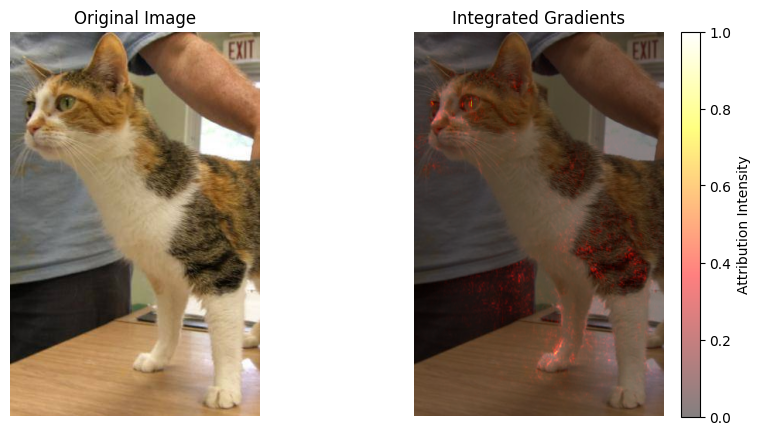

In [228]:
ig_attr=integratedGrad(model, input_tensor.to(device), predicted.item())
ig_attr=ig_attr.squeeze().cpu().detach().numpy()
visualize(ig_attr, og_image, original_size, 'Integrated Gradients')

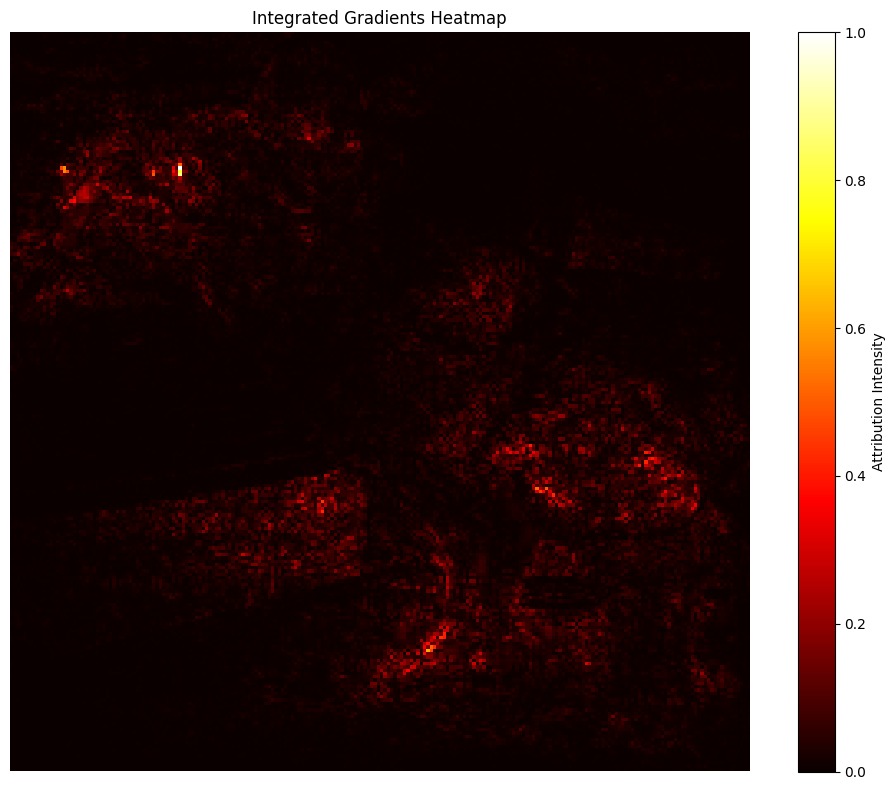

In [225]:
def visualize_heatmap(attr, title):
    if isinstance(attr, torch.Tensor):
        attr = attr.squeeze().cpu().detach().numpy()
    if attr.ndim == 4:
        attr = attr.squeeze(0)
    heatmap = np.sum(np.abs(attr), axis=0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, cmap='hot')
    plt.colorbar(label='Attribution Intensity')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_heatmap(ig_attr, 'Integrated Gradients Heatmap')


In [226]:
def visualizeGCM(attr, og_image, title):
    if not isinstance(attr, np.ndarray):
        attr = attr.cpu().detach().numpy()
    attr_resized = cv2.resize(attr, (og_image.shape[1], og_image.shape[0]))
    attr_normalized = (attr_resized - attr_resized.min()) / (attr_resized.max() - attr_resized.min())
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(og_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(og_image)
    plt.imshow(attr_normalized, cmap='jet', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.colorbar(label='Attribution Intensity')
    plt.tight_layout()
    plt.show()

Visualize gradient CAM.

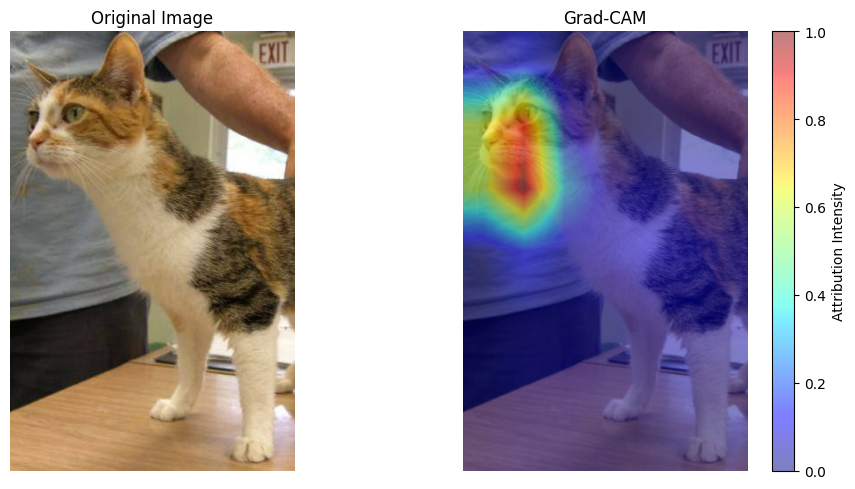

In [227]:
gc_attr = gradCAM(model, input_tensor.to(device), predicted.item())
visualizeGCM(gc_attr, og_image, 'Grad-CAM')